# Exploring FSTs for Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from arsenal import timeit
from IPython.display import HTML
from genparse import FST, Float, CFGLM
from genparse.lm import MockLLM
from genparse.cfglm import locally_normalize, EOS, pcfg_check
from genparse.proposal import TokenProposal
from genparse.util import (
    LarkStuff,
    hf_tokenizer,
    about,
    bpe2term_approx,
)
from genparse.trace import TraceSWOR

WARNING 06-30 00:04:44 _custom_ops.py:14] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [3]:
lark_stuff = LarkStuff(
    r"""

start: NAME

NAME: /(a|b)*c/

"""
)
foo = lark_stuff.char_cfg(decay=0.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

✔ PCFG


True

In [4]:
foo

Grammar {
  1.0: 0 → NAME
  1.0: NAME → ('NAME', 0)
  1.0: ('NAME', 1) → 
  0.03333333333333333: ('NAME', 0) → a ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → b ('NAME', 0)
  0.9333333333576115: ('NAME', 0) → c ('NAME', 1)
}

In [5]:
foo.cnf.language(3)

key,value
"('c',)",0.9333333333576115
"('b', 'c')",0.031111111111920383
"('b', 'b', 'c')",0.0010370370370640127
"('b', 'a', 'c')",0.0010370370370640127
"('a', 'c')",0.031111111111920383
"('a', 'b', 'c')",0.0010370370370640127
"('a', 'a', 'c')",0.0010370370370640127


In [6]:
lm = CFGLM(foo)

In [7]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 (('c',), 0.9333333333333406)
1 (('a', 'c'), 0.03111111111110799)
2 (('b', 'c'), 0.03111111111110799)
3 (('a', 'a', 'c'), 0.001037037037036821)
4 (('b', 'a', 'c'), 0.001037037037036821)
5 (('a', 'b', 'c'), 0.001037037037036821)
6 (('b', 'b', 'c'), 0.001037037037036821)
7 (('b', 'b', 'b', 'c'), 3.456790123455696e-05)
8 (('b', 'a', 'a', 'c'), 3.456790123455696e-05)
9 (('b', 'b', 'a', 'c'), 3.456790123455696e-05)
10 (('a', 'b', 'b', 'c'), 3.456790123455696e-05)
11 (('a', 'a', 'a', 'c'), 3.456790123455696e-05)
12 (('a', 'a', 'b', 'c'), 3.456790123455696e-05)
13 (('a', 'b', 'a', 'c'), 3.456790123455696e-05)
14 (('b', 'a', 'a', 'a', 'c'), 1.1522633744851077e-06)


In [8]:
H = hf_tokenizer()
about(H.fst)

states: 98036, trim: 98036


Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [9]:
# b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber
# about(b2c)

In [10]:
b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

('c',)
total weight of BPE sequences (i.e., ambiguity): 1.0


('b', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


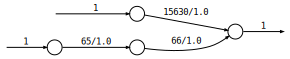

('b', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


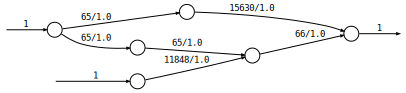

('b', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


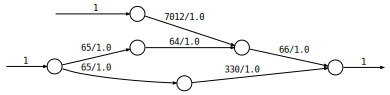

('a', 'c')
total weight of BPE sequences (i.e., ambiguity): 2.0


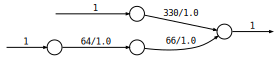

('a', 'b', 'c')
total weight of BPE sequences (i.e., ambiguity): 4.0


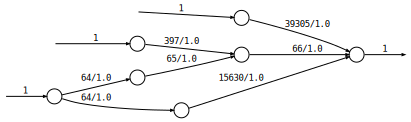

('a', 'a', 'c')
total weight of BPE sequences (i.e., ambiguity): 3.0


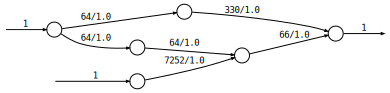

In [11]:
for x in foo.cnf.language(3):
    display(HTML('<hr/>'))
    print(x)
    bpe_x = b2c(None, x).epsremove.trim
    print('total weight of BPE sequences (i.e., ambiguity):', bpe_x.total_weight())
    display(bpe_x)
    print()

In [12]:
tmp = (b2c @ foo).trim()

In [13]:
L = 5

In [14]:
c = Float.chart()
for (
    x,
    w,
) in tmp.cnf.language(5).items():
    y = H.tokenizer.decode(x)
    if len(y) > L:
        continue
    c[y] += w

In [15]:
ambig = Float.chart({x: b2c(None, x).total_weight() for x in c})

In [16]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [17]:
cc = Float.chart()
for x, w in foo.cnf.language(L + 2).items():
    if len(x) > L:
        continue
    cc[''.join(x)] += w
# cc

In [18]:
ccc.assert_equal(cc, tol=1e-20)

In [19]:
# cc.metric(c)

In [20]:
# tmp.trim(bottomup_only=True)

In [21]:
# show_grammar(tmp, showzero=True)

In [22]:
# print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [23]:
# for q in c2t.states:
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [24]:
# {x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [25]:
# len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [26]:
# tmp.cnf.language(4)

In [27]:
# show_grammar(tmp)

In [28]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()
pcfg_check(p)

✔ PCFG


True

In [29]:
lm2 = CFGLM(p)

In [30]:
# lm2.sample(verbose=1)

In [31]:
# context = (64,65,6485,39305)
context = (
    64,
    65,
    6485,
)

In [32]:
char_context = H.tokenizer.decode(context)
char_context

'ababb'

In [33]:
df = []
for x, w in sorted(lm2.p_next(context).normalize().items(), key=lambda kv: -kv[1]):
    df.append((x, (H.tokenizer.decode([x]) if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

,chars,prob
token_id,,
66,c,0.869821
64,a,0.033333
65,b,0.033333
15630,bc,0.028994
330,ac,0.028994
11848,bb,0.001111
397,ab,0.001111
7252,aa,0.001111
7012,ba,0.001111


In [34]:
lm.p_next(char_context).normalize()

key,value
c,0.9333333333333405
b,0.03333333333332973
a,0.03333333333332973


## Lexing

In [35]:
lark_stuff = LarkStuff(
    r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

"""
)

In [36]:
foo = lark_stuff.char_cfg(0.1)

In [37]:
# foo['NAME'].trim().agenda()

In [38]:
# foo.agenda()

In [39]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [40]:
# foo

In [41]:
lm = CFGLM(foo)

In [42]:
trace = TraceSWOR()
for _ in range(15):
    print('mass=', trace.root.mass)
    with trace:
        print(''.join(lm.sample(draw=trace, prob=False)))

mass= 1.0
SELECT * FROM nz </s>
mass= 0.9998712672786743
SELECT * FROM n </s>
mass= 0.9651134325208375
SELECT * FROM dx </s>
mass= 0.9649846997995122
SELECT * FROM l </s>
mass= 0.9302268650416753
SELECT * FROM te </s>
mass= 0.93009813232035
SELECT * FROM x </s>
mass= 0.8953402975625131
SELECT * FROM u </s>
mass= 0.8605824628046762
SELECT * FROM h </s>
mass= 0.8258246280468394
SELECT * FROM z </s>
mass= 0.7910667932890025
SELECT * FROM s </s>
mass= 0.7563089585311656
SELECT * FROM v </s>
mass= 0.7215511237733288
SELECT * FROM i </s>
mass= 0.6867932890154919
SELECT * FROM b </s>
mass= 0.652035454257655
SELECT * FROM e </s>
mass= 0.6172776194998181
SELECT * FROM c </s>


In [43]:
cfg = lark_stuff.convert().renumber()

In [44]:
c2t = lark_stuff.transducer(ignore='', decay=0.0125)
len(c2t.states)

25

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [45]:
x = 'SELECT * FROM data'

In [46]:
list(lark_stuff.lex(x))

[Token('SELECT', 'SELECT'),
 Token('WS', ' '),
 Token('STAR', '*'),
 Token('WS', ' '),
 Token('FROM', 'FROM'),
 Token('WS', ' '),
 Token('NAME', 'data')]

However, this string can lex many different ways:

In [47]:
ambig = (
    (FST.from_string(x, Float) @ c2t)
    .trim.project(1)
    .epsremove.trim.to_cfg()
    .cnf.language(15)
)

In [48]:
# ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [49]:
for y in ambig:
    v = cfg.prefix_weight(y)  # show all options with a nonzero prefix weight
    if v == 0:
        continue
    print(v, y)

1.0 ('SELECT', 'WS', 'STAR', 'WS', 'FROM', 'WS', 'NAME')


In [50]:
# ((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [51]:
# (P.T @ cfg).trim().cnf.language(100)

In [52]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [53]:
pcfg_check(pcfg_t)

✔ PCFG


True

In [54]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [55]:
cfg_t('SELECT * FROM data </s>')

2.1175823681357538e-46

In [56]:
lm = CFGLM(pcfg_t.cnf)

In [57]:
for _ in range(10):
    print(''.join(lm.sample(prob=False)))

SELECT * FROM i </s>
SELECT * FROM h </s>
SELECT * FROM s </s>
SELECT * FROM k </s>
SELECT * FROM q </s>
SELECT * FROM omgk </s>
SELECT * FROM y </s>
SELECT * FROM v </s>
SELECT * FROM a </s>
SELECT * FROM e </s>


In [58]:
lm.p_next('SELECT * FROM ')

key,value
l,0.03846153846151434
e,0.03846153846151434
f,0.03846153846151434
h,0.03846153846151434
x,0.03846153846151434
k,0.03846153846151434
r,0.03846153846151434
m,0.03846153846151434
i,0.03846153846151434
q,0.03846153846151434


## BPE Basics

In [59]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [60]:
b2c = hf_tk.fst
len(b2c.states)

98036

In [61]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

[46506, 1635, 16034, 1366]

In [62]:
[tokenizer.decode([bb]) for bb in b]

['SELECT', ' *', ' FROM', ' data']

In [63]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

composition (6.6521 sec)


states: 490180, trim: 23


In [64]:
c.trim

We can build this "transducer" more efficiently

In [65]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [66]:
x = x = 'SELECT * FROM data'

In [67]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

states: 68, trim: 68


composition (0.7944 sec)
trim (0.0010 sec)


In [68]:
# bs.trim

The automaton below describes all the BPE sequences that generate the string `x` and the number below is the total weight of these paths (in the count semiring these are the number of distinct paths):

In [69]:
bs.trim.project(0).epsremove.trim.total_weight()

7904.0

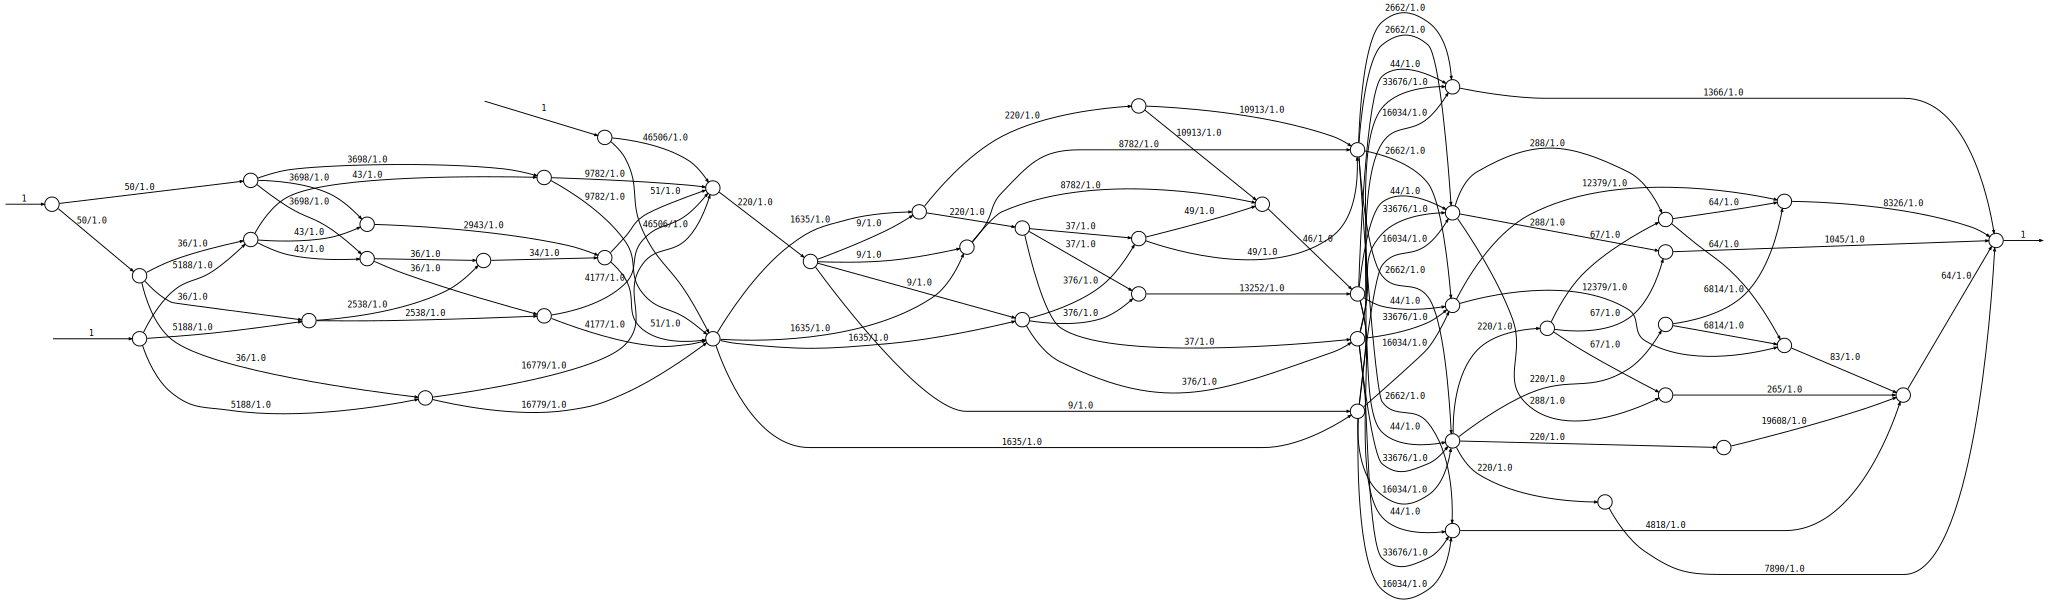

In [70]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [71]:
# for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## The Grafting Heuristic

In [72]:
lark_stuff = LarkStuff(
    r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
"""
)

foo = lark_stuff.char_cfg(0.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(foo)

In [73]:
print(''.join(lm.sample(prob=False)))

SELECT * FROM data </s>


In [74]:
H = hf_tokenizer()

In [75]:
bpe_lm = TokenProposal(
    guide=lm, llm=MockLLM(V={x for _, x in H.pairs}, eos=H.tokenizer.eos_token)
)

In [76]:
lm.p_next('')

key,value
S,1.0


In [77]:
bpe_lm._prompt = ''
bpe_lm._p_next('')

key,value
S,0.3333333333333333
SE,0.3333333333333333
SELECT,0.3333333333333333


In [78]:
lm.p_next('SELECT ')

key,value
s,0.0004910651320515284
*,0.9699939597005802
y,0.005962835359556556
g,0.0029217893261827125
v,0.005962835359556556
M,0.0007364284897713605
z,0.0020452525283278984
C,0.0010520406996733724
r,0.00016843534029367416
a,0.008518336227937937


In [79]:
bpe_lm._p_next('SELECT ')

key,value
*,0.969835318145591
a,0.008516943062453135
v,0.005961860143717195
y,0.005961860143717195
g,0.0029213114704214256
A,0.002146670692765343
z,0.002044918029294997
C,0.0010518686394550183
M,0.0007363080476185127
s,0.0004909848188337289


In [80]:
ys = bpe_lm.sample()
ys

('SELECT * FROM data </s>', 9.006606233595843e-06)